<a href="https://colab.research.google.com/github/19121A0531/weather-image-recognition-using-deep-learning/blob/main/SRP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import Callback,ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from keras.layers import Dense

In [ ]:
path = '/content/drive/MyDrive/Weather_images'
path_imgs = list(glob.glob(path+'/**/*.jpg'))


In [ ]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_imgs))
file_path = pd.Series(path_imgs, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()


,File_Path,Labels
0,/content/drive/MyDrive/Weather_images/hail/004...,hail
1,/content/drive/MyDrive/Weather_images/glaze/65...,glaze
2,/content/drive/MyDrive/Weather_images/sandstor...,sandstorm
3,/content/drive/MyDrive/Weather_images/rime/494...,rime
4,/content/drive/MyDrive/Weather_images/rainbow/...,rainbow


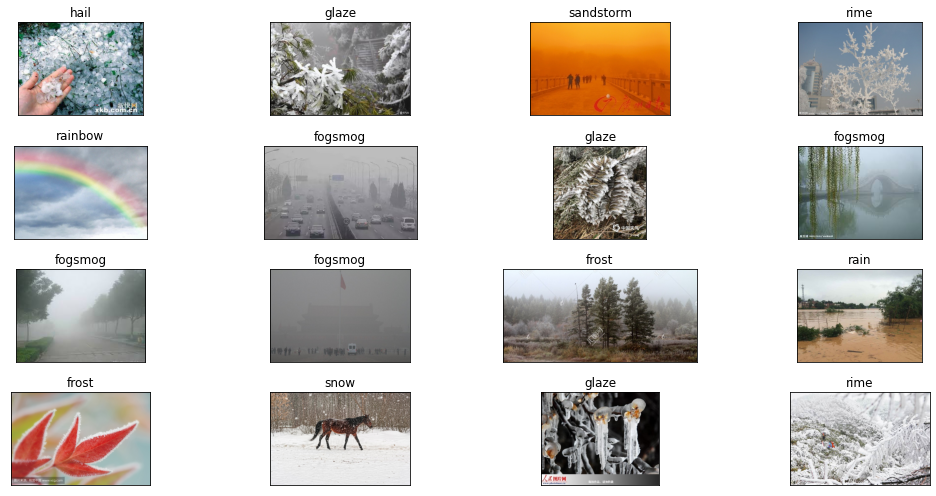

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()

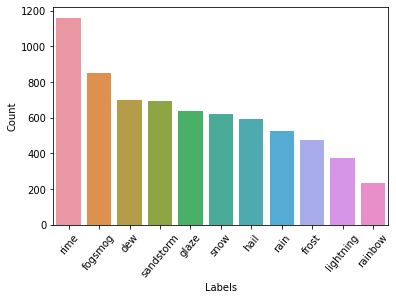

In [ ]:
counts = data.Labels.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);

In [ ]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=2)

In [ ]:
def gen(pre,train,test):
    train_datagen = ImageDataGenerator(preprocessing_function=pre, validation_split=0.2)
    test_datagen = ImageDataGenerator(preprocessing_function=pre)
    
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        verbose=0,
        shuffle=False)
    return train_gen, valid_gen, test_gen

In [ ]:
def func1(name_model):
    pre_model = name_model(input_shape=(100,100, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(100, activation='relu')(pre_model.output)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(11, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer= keras.optimizers.RMSprop(learning_rate = .00001),metrics=['accuracy'])
    
    return model

In [ ]:
def plot(history,test_gen,train_gen,model):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Validation'])
        
    # Predict Data Test
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    # Classification report
    cm=confusion_matrix(test_df.Labels,pred)
    clr = classification_report(test_df.Labels, pred)
    print(clr)
    # Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_df.File_Path.iloc[i+1]))
        ax.set_title(f"True: {test_df.Labels.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
        
    return history

In [ ]:
def result_test(test,model_use):
    results = model_use.evaluate(test, verbose=0)
    
    print("    Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))
    
    return results

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
17235968/17225924 [==============================] - 0s 0us/step
Epoch 1/100
138/138 [==============================] - 1222s 9s/step - loss: 2.6217 - accuracy: 0.1396 - val_loss: 2.4620 - val_accuracy: 0.1759
Epoch 2/100
138/138 [==============================] - 68s 490ms/step - loss: 2.3781 - accuracy: 0.1922 - val_loss: 2.2708 - val_accuracy: 0.2233
Epoch 3/100
138/138 [==============================] - 68s 495ms/step - loss: 2.1992 - accuracy: 0.2543 - val_loss: 2.1190 - val_accuracy: 0.2799
Epoch 4/100
138/138 [==============================] - 67s 480ms/step - loss: 2.0511 - accuracy: 0.3112 - val_loss: 1.9870 - val_accuracy: 0.3418
Epoch 5/100
138/138 [==============================] - 69s 498ms/step - loss: 1.9200 - accuracy: 0.3659 - val_loss: 1.8673 - val_accuracy: 0.3865
Epoch 6/100
138/138 

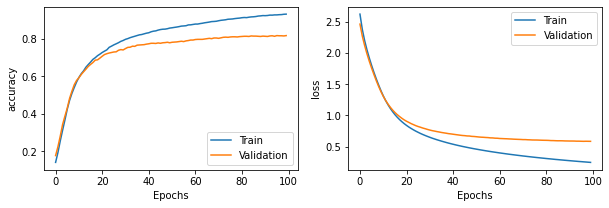

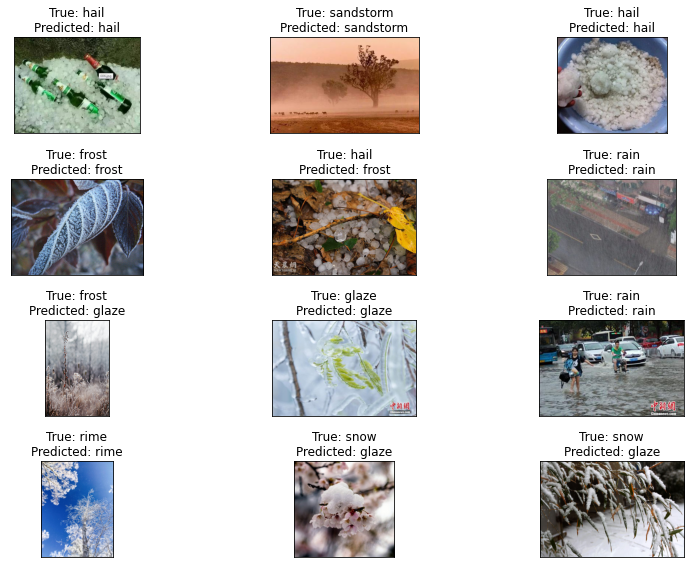

    Test Loss: 0.60292
Test Accuracy: 81.14%


In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
MobileNet_pre=preprocess_input
train_gen_MobileNet, valid_gen_MobileNet, test_gen_MobileNet = gen(MobileNet_pre,train_df,test_df)
MobileNet_model =func(MobileNet)
history = MobileNet_model.fit(
    train_gen_MobileNet,
    validation_data=valid_gen_MobileNet,
    epochs=100,
    verbose=1
)
history_MobileNet = plot(history,test_gen_MobileNet,train_gen_MobileNet, MobileNet_model)

result_MobileNet = result_test(test_gen_MobileNet,MobileNet_model)

In [ ]:
import pickle
with open('mobilenet_100.pickle','wb') as modelFile:
     pickle.dump(MobileNet_model,modelFile)

INFO:tensorflow:Assets written to: ram://023714cd-645c-45d6-b544-168a938596d4/assets


In [ ]:
#RUN FROM HERE
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
MobileNet_pre=preprocess_input
train_gen_MobileNet, valid_gen_MobileNet, test_gen_MobileNet = gen(MobileNet_pre,train_df,test_df)

Found 4392 validated image filenames belonging to 11 classes.
Found 1098 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.


11


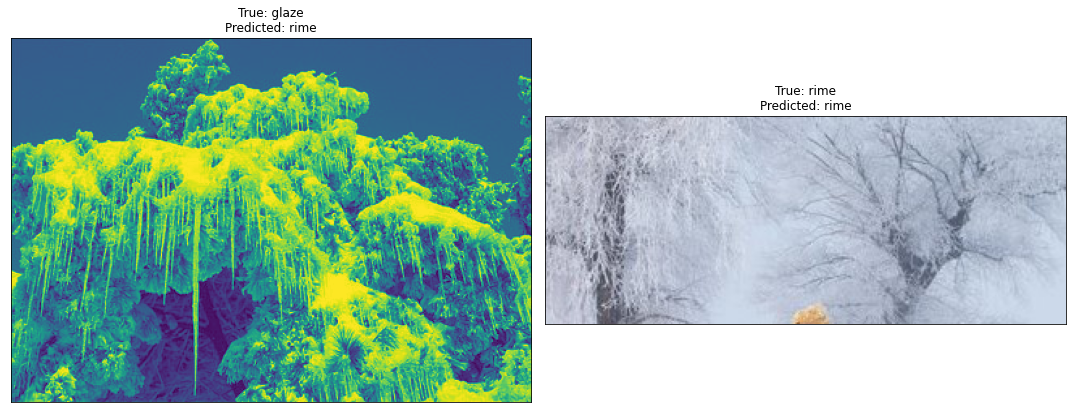

In [ ]:
#predicting using mobilenet_100
import pickle
with open('/content/drive/MyDrive/weather_pickle/mobilenet_100.pickle','rb') as modelFile:
     model = pickle.load(modelFile)
#Predict with the test set
test_df1 = test_df
pred1 = model.predict(test_gen_MobileNet)

pred1 = np.argmax(pred1,axis=1)
labels = (test_gen_MobileNet.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(len(labels))
pred1 = [labels[k] for k in pred1]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df1.File_Path.iloc[i+1]))
    ax.set_title(f"True: {test_df1.Labels.iloc[i+1]}\nPredicted: {pred1[i+1]}")
plt.tight_layout()
plt.show()

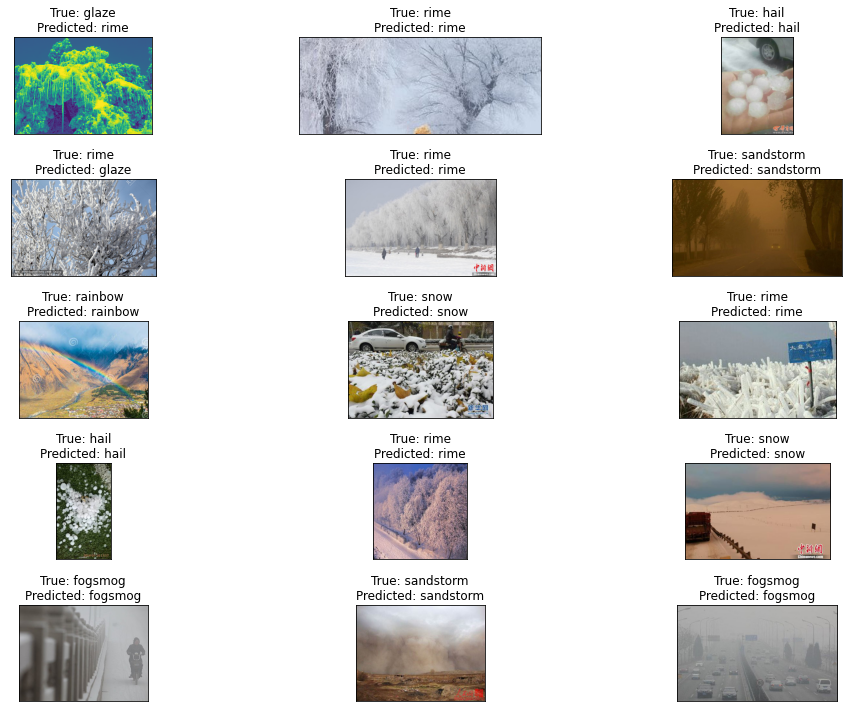

    Test Loss: 0.38020
Test Accuracy: 89.08%


In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df1.File_Path.iloc[i+1]))
    ax.set_title(f"True: {test_df1.Labels.iloc[i+1]}\nPredicted: {pred1[i+1]}")
plt.tight_layout()
plt.show()
result_MobileNet = result_test(test_gen_MobileNet,model)

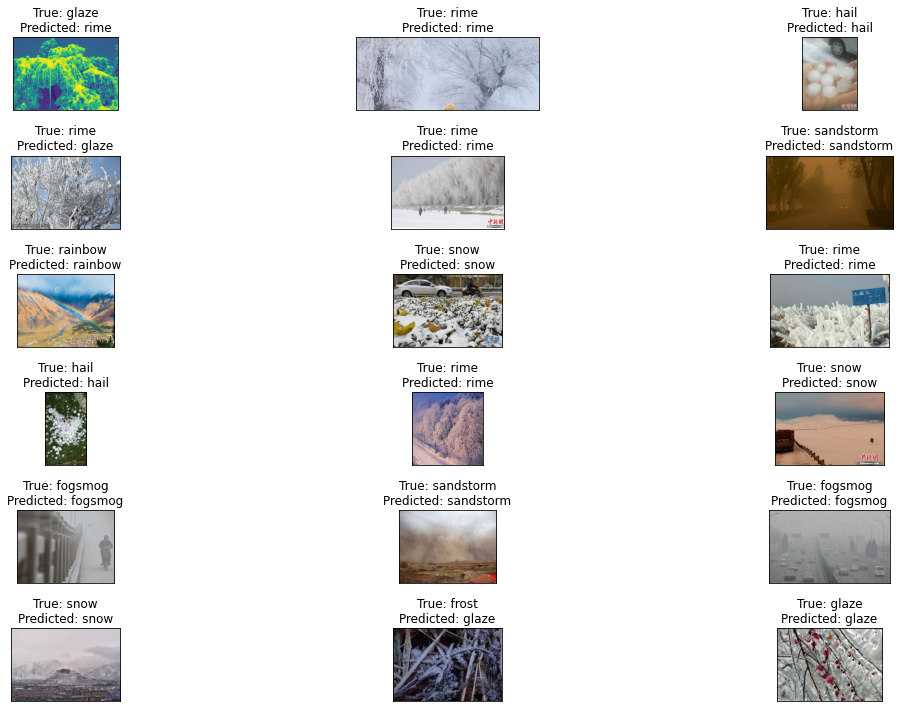

    Test Loss: 0.38020
Test Accuracy: 89.08%


In [ ]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(18, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df1.File_Path.iloc[i+1]))
    ax.set_title(f"True: {test_df1.Labels.iloc[i+1]}\nPredicted: {pred1[i+1]}")
plt.tight_layout()
plt.show()
result_MobileNet = result_test(test_gen_MobileNet,model)

Using different Optimizers

In [ ]:
#mobilenet with SGD Optimizer
def func(name_model):
    pre_model = name_model(input_shape=(100,100, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(100, activation='relu')(pre_model.output)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(11, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()])
    
    return model


from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
MobileNet_pre=preprocess_input
train_gen_MobileNet, valid_gen_MobileNet, test_gen_MobileNet = gen(MobileNet_pre,train_df,test_df)
MobileNet_model =func(MobileNet)
history_sgd = MobileNet_model.fit(
    train_gen_MobileNet,
    validation_data=valid_gen_MobileNet,
    epochs=50,
    verbose=1
)


Found 4392 validated image filenames belonging to 11 classes.
Found 1098 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
Epoch 1/50
138/138 [==============================] - 74s 524ms/step - loss: 2.4364 - categorical_accuracy: 0.1737 - val_loss: 2.2027 - val_categorical_accuracy: 0.2805
Epoch 2/50
138/138 [==============================] - 72s 520ms/step - loss: 2.0318 - categorical_accuracy: 0.3370 - val_loss: 1.8898 - val_categorical_accuracy: 0.4007
Epoch 3/50
138/138 [==============================] - 71s 513ms/step - loss: 1.7416 - categorical_accuracy: 0.4606 - val_loss: 1.6355 - val_categorical_accuracy: 0.5009
Epoch 4/50
138/138 [==============================] - 70s 509ms/step - loss: 1.5014 - categorical_accuracy: 0.5401 - val_loss: 1.4344 - val_categorical_accuracy: 0.5601
Epoch 5/50
138/138 [==============================] - 71s 513ms/step - loss: 1.3164 - categorical_accuracy: 0.5927 - val_loss: 1.2865 - va

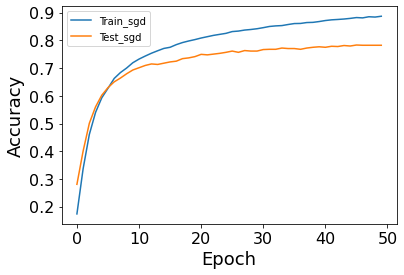

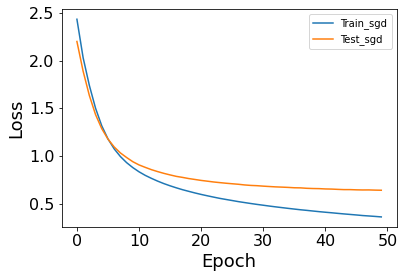

    Test Loss: 0.64432
Test Accuracy: 79.83%


In [ ]:
import matplotlib.pyplot as plt
plt.plot(history_sgd.history['categorical_accuracy'])
plt.plot(history_sgd.history['val_categorical_accuracy'])
plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['Train_sgd','Test_sgd'], loc='best')
plt.show()
#loss
plt.plot(history_sgd.history['loss'])
plt.plot(history_sgd.history['val_loss'])
plt.ylabel('Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['Train_sgd','Test_sgd'], loc='best')
plt.show()

result_MobileNet = result_test(test_gen_MobileNet,MobileNet_model)

In [ ]:
import pickle
with open('/content/drive/MyDrive/weather_pickle/sgd_history', 'wb') as file_pi:
  pickle.dump(history_sgd.history, file_pi)
np.save('/content/drive/MyDrive/weather_pickle/sgd_history.npy',history_sgd.history)

INFO:tensorflow:Assets written to: ram://ef2f90cb-1de0-45ef-9746-858ad783a986/assets


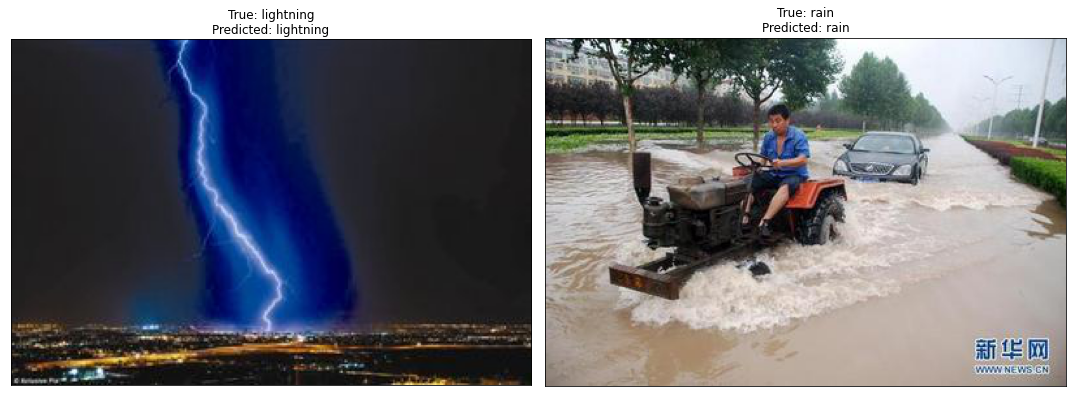

In [ ]:
with open('/content/drive/MyDrive/weather_pickle/sgd/sgd_predict', 'wb') as file_pi:
  pickle.dump(MobileNet_model, file_pi)
with open('/content/drive/MyDrive/weather_pickle/sgd/sgd_predict','rb') as modelFile:
     model = pickle.load(modelFile)
#Predict with the test set
test_df1 = test_df
pred2 = model.predict(test_gen_MobileNet)

pred2 = np.argmax(pred2,axis=1)
labels = (test_gen_MobileNet.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred2]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df1.File_Path.iloc[i+1]))
    ax.set_title(f"True: {test_df1.Labels.iloc[i+1]}\nPredicted: {pred2[i+1]}")
plt.tight_layout()
plt.show()


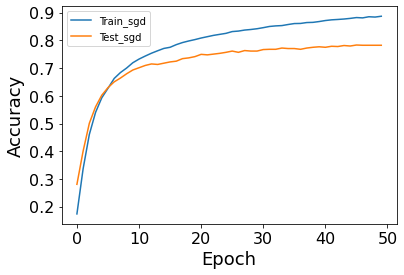

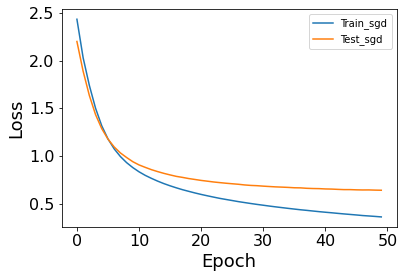

In [ ]:
import numpy as np
sgd_history = np.load('/content/drive/MyDrive/weather_pickle/sgd_history.npy', allow_pickle=True).item()

plt.plot(sgd_history['categorical_accuracy'])
plt.plot(sgd_history['val_categorical_accuracy'])
plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['Train_sgd','Test_sgd'], loc='best')
plt.show()
#loss
plt.plot(sgd_history['loss'])
plt.plot(sgd_history['val_loss'])
plt.ylabel('Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['Train_sgd','Test_sgd'], loc='best')
plt.show()


In [ ]:
#Adam Optimizer with learning rate
def func(name_model):
    pre_model = name_model(input_shape=(100,100, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(100, activation='relu')(pre_model.output)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(11, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],)
    
    return model



from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
MobileNet_pre=preprocess_input
train_gen_MobileNet, valid_gen_MobileNet, test_gen_MobileNet = gen(MobileNet_pre,train_df,test_df)
MobileNet_model =func(MobileNet)
history_adam = MobileNet_model.fit(
    train_gen_MobileNet,
    validation_data=valid_gen_MobileNet,
    epochs=50,
    verbose=1
)



Using different models for the same data


1.   ResNet50
2.   VGG16
3.   DenseNet201





In [ ]:
#resnet50_epoch=50
def func1(name_model):
    pre_model = name_model(input_shape=(100,100, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(100, activation='relu')(pre_model.output)
    x = Dense(100, activation='relu')(x)
    outputs = Dense(11, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer= keras.optimizers.RMSprop(learning_rate = .00001),metrics=['accuracy'])
    
    return model


from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
ResNet_pre=preprocess_input
train_gen_ResNet, valid_gen_ResNet, test_gen_ResNet = gen(ResNet_pre,train_df,test_df)
ResNet_model=func1(ResNet50)
filepath = '/content/drive/MyDrive/weather_pickle/resnet_model_50epoch.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')
callbacks = [checkpoint]
resnet_history = ResNet_model.fit(
    train_gen_ResNet,
    validation_data=valid_gen_ResNet,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)
with open('/content/drive/MyDrive/weather_pickle/RMSprop/Resnet50_history_50epoch', 'wb') as file_pi:
  pickle.dump(resnet_history.history, file_pi)
with open('/content/drive/MyDrive/weather_pickle/RMSprop/Resnet50_predict_50epoch', 'wb') as modelfile:
  pickle.dump(ResNet_model, modelfile)

np.save('/content/drive/MyDrive/weather_pickle/RMSprop/Resnet50_history_50epoch.npy',resnet_history.history)
history_MobileNet = plot(resnet_history,test_gen_ResNet,train_gen_ResNet, ResNet_model)


result_ResNet = result_test(test_gen_ResNet,ResNet_model)

In [ ]:
#vgg16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

vgg_pre=preprocess_input
train_gen_VGG, valid_gen_VGG, test_gen_VGG = gen(vgg_pre,train_df,test_df)
model_VGG16=func1(VGG16)
vgg16_history = model_VGG16.fit(
    train_gen_VGG,
    validation_data=valid_gen_VGG,
    epochs=100,
    verbose=1
)
with open('/content/drive/MyDrive/weather_pickle/RMSprop/vgg16_history', 'wb') as file_pi:
  pickle.dump(vgg16_history.history, file_pi)
with open('/content/drive/MyDrive/weather_pickle/RMSprop/vgg16_predict', 'wb') as modelfile:
  pickle.dump(model_VGG16, modelfile)

np.save('/content/drive/MyDrive/weather_pickle/RMSprop/vgg16_history.npy',vgg16_history.history)

result_VGG16 = result_test(test_gen_VGG,model_VGG16)

In [ ]:
#densenet201
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input

DenseNet201_pre=preprocess_input
train_gen_DenseNet201, valid_gen_DenseNet201, test_gen_DenseNet201 = gen(DenseNet201_pre,train_df,test_df)
model_DenseNet201=func1(DenseNet201)
densenet201_history = model_DenseNet201.fit(
    train_gen_DenseNet201,
    validation_data=valid_gen_DenseNet201,
    epochs=100,
    verbose=1
)
with open('/content/drive/MyDrive/weather_pickle/RMSprop/densenet201_history', 'wb') as file_pi:
  pickle.dump(densenet201_history.history, file_pi)
with open('/content/drive/MyDrive/weather_pickle/RMSprop/densenet201_predict', 'wb') as modelfile:
  pickle.dump(model_DenseNet201, modelfile)

np.save('/content/drive/MyDrive/weather_pickle/RMSprop/vgg16_history.npy',densenet201_history.history)
result_DenseNet201 = result_test(test_gen_DenseNet201,model_DenseNet201)

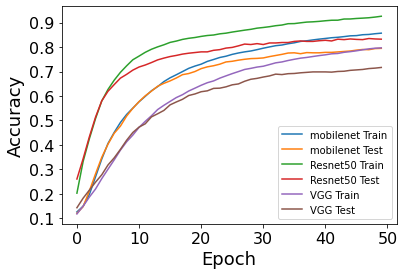

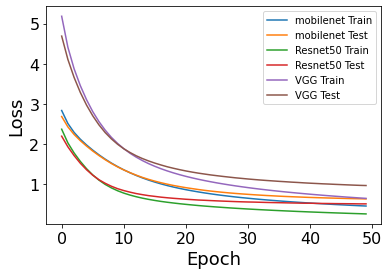

In [ ]:
#GRAPHS FOR MOBILENET RESNET VGG16 both train and test
import numpy as np
import pickle
with open('/content/drive/MyDrive/fitted_model.pickle','rb') as modelFile:
     mobilenet_history = pickle.load(modelFile)
resnet_history = np.load('/content/drive/MyDrive/weather_pickle/RMSprop/Resnet50_history_50epoch.npy', allow_pickle=True).item()
vgg16_history = np.load('/content/drive/MyDrive/weather_pickle/RMSprop/vgg16_history.npy', allow_pickle=True).item()
import matplotlib.pyplot as plt
plt.plot(mobilenet_history.history['accuracy'])
plt.plot(mobilenet_history.history['val_accuracy'])

plt.plot(resnet_history['accuracy'])
plt.plot(resnet_history['val_accuracy'])

plt.plot(vgg16_history['accuracy'])
plt.plot(vgg16_history['val_accuracy'])

plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['mobilenet Train', 'mobilenet Test', 'Resnet50 Train', 'Resnet50 Test', 'VGG Train', 'VGG Test'], loc='best')
plt.show()
#loss
plt.plot(mobilenet_history.history['loss'])
plt.plot(mobilenet_history.history['val_loss'])

plt.plot(resnet_history['loss'])
plt.plot(resnet_history['val_loss'])

plt.plot(vgg16_history['loss'])
plt.plot(vgg16_history['val_loss'])

plt.ylabel('Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['mobilenet Train', 'mobilenet Test', 'Resnet50 Train', 'Resnet50 Test', 'VGG Train', 'VGG Test'], loc='best')
plt.show()

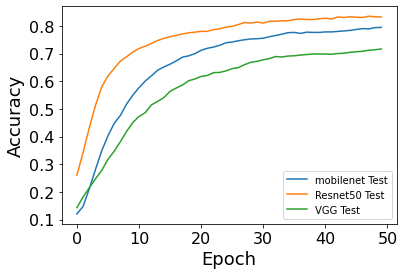

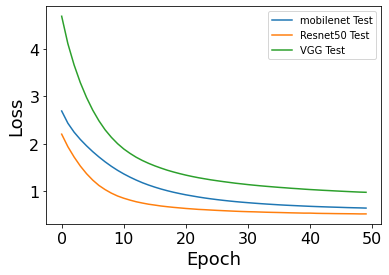

In [ ]:
import numpy as np
import pickle
with open('/content/drive/MyDrive/fitted_model.pickle','rb') as modelFile:
     mobilenet_history = pickle.load(modelFile)
resnet_history = np.load('/content/drive/MyDrive/weather_pickle/RMSprop/Resnet50_history_50epoch.npy', allow_pickle=True).item()
vgg16_history = np.load('/content/drive/MyDrive/weather_pickle/RMSprop/vgg16_history.npy', allow_pickle=True).item()
import matplotlib.pyplot as plt

plt.plot(mobilenet_history.history['val_accuracy'])


plt.plot(resnet_history['val_accuracy'])


plt.plot(vgg16_history['val_accuracy'])

plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend([ 'mobilenet Test',  'Resnet50 Test',  'VGG Test'], loc='best')
plt.show()
#loss

plt.plot(mobilenet_history.history['val_loss'])


plt.plot(resnet_history['val_loss'])


plt.plot(vgg16_history['val_loss'])

plt.ylabel('Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['mobilenet Test',  'Resnet50 Test',  'VGG Test'], loc='best')
plt.show()

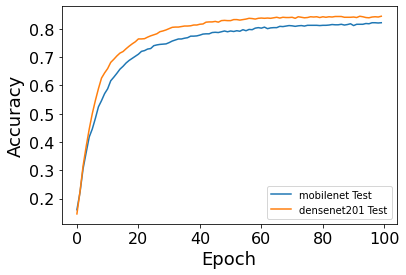

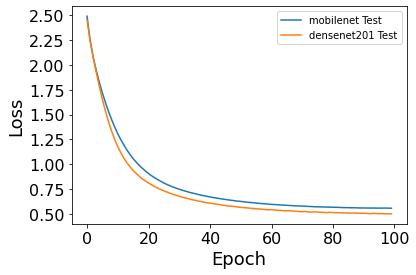

In [ ]:
#GRAPHS FOR MOBILENET AND DENSENET201 for 100 epoch
import numpy as np
import pickle
with open('/content/drive/MyDrive/weather_100.pickle','rb') as modelFile:
     mobilenet_history = pickle.load(modelFile)
densenet_history = np.load('/content/drive/MyDrive/weather_pickle/RMSprop/densenet201_history.npy', allow_pickle=True).item()
import matplotlib.pyplot as plt

plt.plot(mobilenet_history.history['val_accuracy'])


plt.plot(densenet_history['val_accuracy'])




plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend([ 'mobilenet Test',  'densenet201 Test'], loc='best')
plt.show()
#loss

plt.plot(mobilenet_history.history['val_loss'])


plt.plot(densenet_history['val_loss'])


plt.ylabel('Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['mobilenet Test',  'densenet201 Test'], loc='best')
plt.show()

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
Epoch 1/100
138/138 [==============================] - 101s 706ms/step - loss: 2.6592 - accuracy: 0.1393 - val_loss: 2.4881 - val_accuracy: 0.1604
Epoch 2/100
138/138 [==============================] - 67s 482ms/step - loss: 2.3315 - accuracy: 0.1860 - val_loss: 2.2484 - val_accuracy: 0.2215
Epoch 3/100
138/138 [==============================] - 69s 499ms/step - loss: 2.1288 - accuracy: 0.2557 - val_loss: 2.0795 - val_accuracy: 0.3054
Epoch 4/100
138/138 [==============================] - 66s 479ms/step - loss: 1.9706 - accuracy: 0.3247 - val_loss: 1.9428 - val_accuracy: 0.3619
Epoch 5/100
138/138 [==============================] - 67s 482ms/step - loss: 1.8352 - accuracy: 0.3798 - val_loss: 1.8244 - val_accuracy: 0.4175
Epoch 6/100
138/138 [==============================] - 67s 487ms/step - loss: 1.715

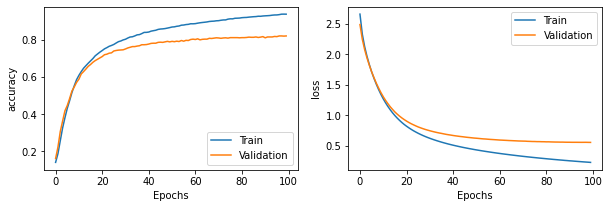

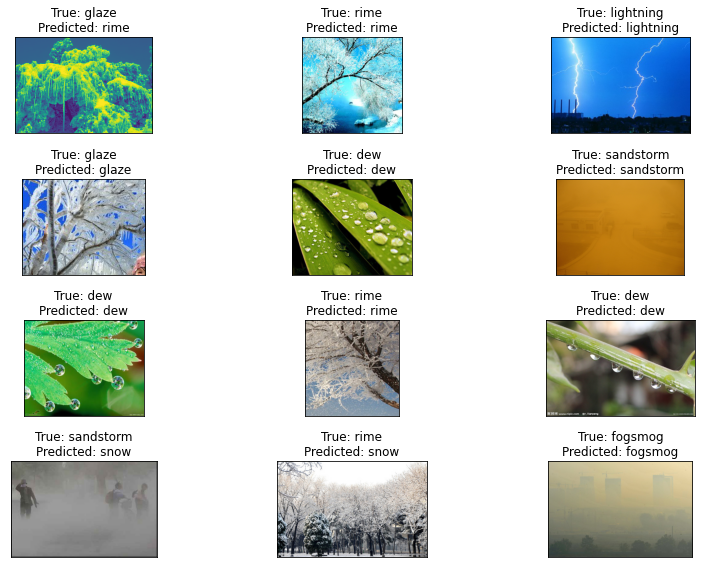

    Test Loss: 0.62351
Test Accuracy: 80.04%


In [ ]:
#Don't delete
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
MobileNet_pre=preprocess_input
train_gen_MobileNet, valid_gen_MobileNet, test_gen_MobileNet = gen(MobileNet_pre,train_df,test_df)
MobileNet_model =func(MobileNet)
history = MobileNet_model.fit(
    train_gen_MobileNet,
    validation_data=valid_gen_MobileNet,
    epochs=100,
    verbose=1
)
history_MobileNet = plot(history,test_gen_MobileNet,train_gen_MobileNet, MobileNet_model)

result_MobileNet = result_test(test_gen_MobileNet,MobileNet_model)